# DenoiSeg Example: Mouse Nuclei
This is an example notebook which illustrates how DenoiSeg should be trained. In this notebook we use nuclei dataset from a mouse skull from our collaborators. We already split the data into train and test images. From the train images we then extracted 908 training and 160 validation patches of size 128x128. The test set contains 67 images of size 256x256.

In [1]:
# Here we are just importing some libraries which are needed to run this notebook.

import warnings
warnings.filterwarnings('ignore')

import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage

from denoiseg.models import DenoiSeg, DenoiSegConfig
from denoiseg.utils.misc_utils import combine_train_test_data, shuffle_train_data, augment_data
from denoiseg.utils.seg_utils import *
from denoiseg.utils.compute_precision_threshold import measure_precision
from denoiseg.utils.denoiseg_data_preprocessing import generate_patches_from_list

from csbdeep.utils import plot_history

import urllib
import os
import zipfile

2023-07-19 17:25:00.201367: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 17:25:01.281930: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Downloading and  Data Loading
We created three versions of this dataset by adding Gaussian noise with zero mean and standard deviations 10 and 20. The dataset are marked with the suffixes n0, n10 and n20 accordingly.

In the next cell you can choose which `noise_level` you would like to investigate.

In [2]:
# Choose the noise level you would like to look at:
# Values: 'n0', 'n10', 'n20'
noise_level = 'n20'

In [6]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')
    
if noise_level == 'n0':
    link = 'https://zenodo.org/record/5157001/files/Mouse_n0.zip?download=1'
elif noise_level == 'n10':
    link = 'https://zenodo.org/record/5157003/files/Mouse_n10.zip?download=1'
elif noise_level == 'n20':
    link = 'https://zenodo.org/record/5157008/files/Mouse_n20.zip?download=1'
else:
    print('This noise level does not exist for this dataset.')

# check if data has been downloaded already
zipPath="data/Mouse_{}.zip".format(noise_level)
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve(link, zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

In [7]:
# Loading of the training images
trainval_data =  np.load('data/Mouse_{}/train/train_data.npz'.format(noise_level))
train_images = trainval_data['X_train'].astype(np.float32)
train_masks = trainval_data['Y_train']
val_images = trainval_data['X_val'].astype(np.float32)
val_masks = trainval_data['Y_val']

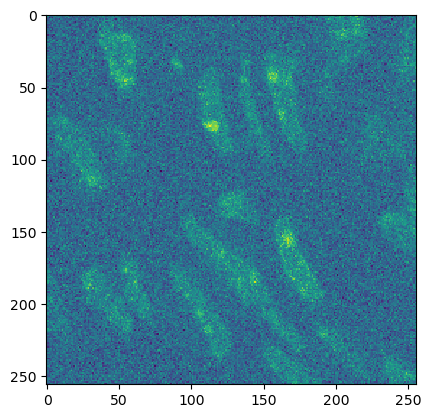

In [8]:
test_data =  np.load('data/Mouse_{}/test/test_data.npz'.format(noise_level))
test_images = test_data['X_test'].astype(np.float32)
test_masks = test_data['Y_test']
plt.imshow(test_images[1])

In [9]:
print("Shape of train_images: {}".format(train_images.shape))
print("Shape of train_masks:  {}".format(train_masks.shape))
print("Shape of val_images:   {}".format(val_images.shape))
print("Shape of val_masks:    {}".format(val_masks.shape))

Shape of train_images: (908, 128, 128)
Shape of train_masks:  (908, 128, 128)
Shape of val_images:   (160, 128, 128)
Shape of val_masks:    (160, 128, 128)


## Small Amounts of Annotated Training Data
With DenoiSeg we present a solution to train deep neural networks if only few annotated ground truth segmentations are available. We simulate such a scenario by zeroing out all but a fraction of the available training data. In the next cell you can specify the percentage of training images for which ground truth annotations are available.

In [10]:
# Set the number of annotated training images.
# Values: 0.0 (no annotated images) to total number of training images (all images have annotations)
number_of_annotated_training_images = 38
assert number_of_annotated_training_images >= 0.0 and number_of_annotated_training_images <=train_images.shape[0]

In [14]:
# Seed to shuffle training data (annotated GT and raw image pairs).
seed = 1 

# First we shuffle the training images to remove any bias.
X_shuffled, Y_shuffled = shuffle_train_data(train_images, train_masks, random_seed=seed)

# Here we convert the number of annotated images to be used for training as percentage of available training data.
percentage_of_annotated_training_images = float((number_of_annotated_training_images/train_images.shape[0]) * 100.0)
assert percentage_of_annotated_training_images >= 0.0 and percentage_of_annotated_training_images <= 100.0

# Here we zero out all training images which are not part of the 
# selected percentage.
X_frac, Y_frac = zero_out_train_data(train_images, train_masks, fraction=percentage_of_annotated_training_images)

# Here we generate patches from images and apply augmentation
X_final, Y_final = generate_patches_from_list([X_frac], [Y_frac], 'SYXC', augment=True, shuffle=False, shape=(128, 128))
X_val_final, Y_val_final = generate_patches_from_list([val_images], [val_masks], 'SYXC', augment=False, shape=(128, 128))

X_final = X_final[... ,np.newaxis]
Y_final = convert_to_oneHot(Y_final, n_classes=3)

X_val_final = X_val_final[... ,np.newaxis]
Y_val_final = convert_to_oneHot(Y_val_final, n_classes=3)

print("Shape of X:     {}".format(X_final.shape))
print("Shape of Y:     {}".format(Y_final.shape))
print("Shape of X_val: {}".format(X_val_final.shape))
print("Shape of Y_val: {}".format(Y_val_final.shape))

Shape of X:     (7264, 128, 128, 1)
Shape of Y:     (7264, 128, 128, 3)
Shape of X_val: (160, 128, 128, 1)
Shape of Y_val: (160, 128, 128, 3)


Next we look at a single sample. In the first column we show the input image, in the second column the background segmentation, in the third column the foreground segmentation and in the last column the border segmentation.

With the parameter `sample` you can choose different training patches. You will notice that not all of them have a segmentation ground truth.

Text(0.5, 1.0, '1-hot encoded border')

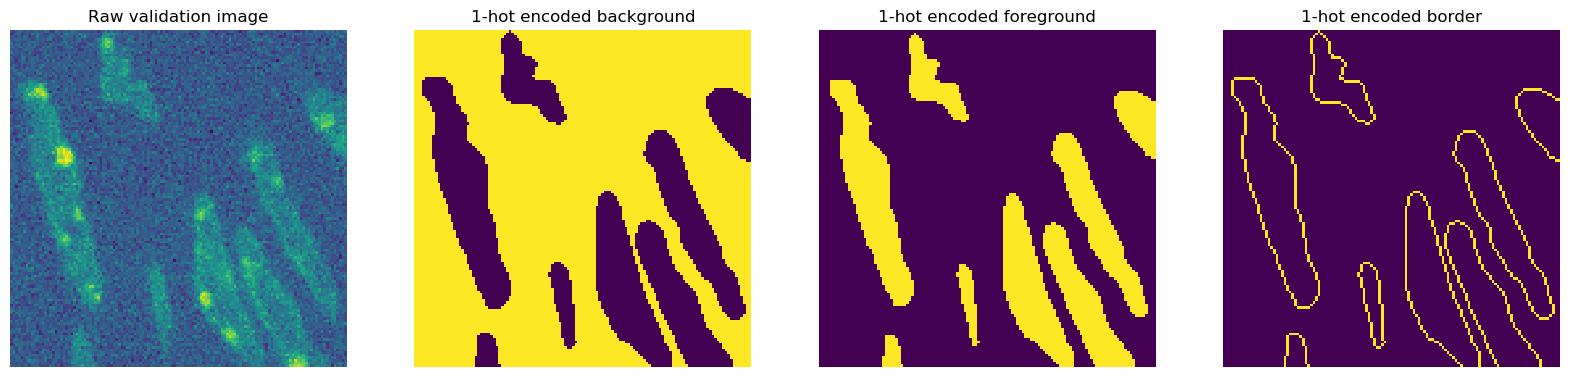

In [15]:
sample = 0
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(X_final[sample,...,0])
plt.axis('off')
plt.title('Raw validation image')
plt.subplot(1,4,2)
plt.imshow(Y_final[sample,...,0], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded background')
plt.subplot(1,4,3)
plt.imshow(Y_final[sample,...,1], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded foreground')
plt.subplot(1,4,4)
plt.imshow(Y_final[sample,...,2], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded border')

### Configure network parameters

In [16]:
train_batch_size = 128
train_steps_per_epoch = min(400, max(int(X_final.shape[0]/train_batch_size), 10))

In [17]:
### In the next cell, you can choose how much relative importance (weight) to assign to denoising 
### and segmentation tasks by choosing appropriate value for denoiseg_alpha (between 0 and 1; with 0 being
### only segmentation and 1 being only denoising. Here we choose denoiseg_alpha = 0.5)

In [18]:
conf = DenoiSegConfig(X_final, unet_kern_size=3, n_channel_in=1, n_channel_out=4, relative_weights = [1.0,1.0,5.0],
                      train_steps_per_epoch=train_steps_per_epoch, train_epochs=10, 
                      batch_norm=True, train_batch_size=train_batch_size, unet_n_first = 32, 
                      unet_n_depth=4, denoiseg_alpha=0.5, train_tensorboard=False)

vars(conf)

{'means': ['23.030106'],
 'stds': ['42.246647'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 4,
 'train_loss': 'denoiseg',
 'unet_n_depth': 4,
 'relative_weights': [1.0, 1.0, 5.0],
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'probabilistic': False,
 'unet_residual': False,
 'unet_input_shape': (None, None, 1),
 'train_epochs': 10,
 'train_steps_per_epoch': 56,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': False,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'train_reduce_lr': {'monitor': 'val_loss', 'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 1.5,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'denoiseg_alpha': 0.5}

In [19]:
model_name = 'DenoiSeg_Mouse_n20'
basedir = 'models'
model = DenoiSeg(conf, model_name, basedir)

2023-07-17 17:06:06.552078: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [20]:
history = model.train(X_final, Y_final, (X_val_final, Y_val_final))

61 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 160/160 [00:01<00:00, 147.77it/s]


Epoch 1/10


2023-07-17 17:06:10.089068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


56/56 [==============================] - 139s 2s/step - loss: 0.2415 - denoiseg: 0.2412 - seg_loss: 0.0286 - denoise_loss: 0.2126 - val_loss: 0.9330 - val_denoiseg: 0.9330 - val_seg_loss: 0.5570 - val_denoise_loss: 0.3760 - lr: 4.0000e-04
Epoch 2/10
56/56 [==============================] - 133s 2s/step - loss: 0.1495 - denoiseg: 0.1496 - seg_loss: 0.0189 - denoise_loss: 0.1307 - val_loss: 0.8211 - val_denoiseg: 0.8211 - val_seg_loss: 0.5249 - val_denoise_loss: 0.2962 - lr: 4.0000e-04
Epoch 3/10
56/56 [==============================] - 135s 2s/step - loss: 0.1410 - denoiseg: 0.1410 - seg_loss: 0.0143 - denoise_loss: 0.1267 - val_loss: 0.6936 - val_denoiseg: 0.6936 - val_seg_loss: 0.4667 - val_denoise_loss: 0.2269 - lr: 4.0000e-04
Epoch 4/10
56/56 [==============================] - 134s 2s/step - loss: 0.1362 - denoiseg: 0.1361 - seg_loss: 0.0119 - denoise_loss: 0.1242 - val_loss: 0.5497 - val_denoiseg: 0.5497 - val_seg_loss: 0.3550 - val_denoise_loss: 0.1947 - lr: 4.0000e-04
Epoch 5/10


In [21]:
history.history.keys()

dict_keys(['loss', 'denoiseg', 'seg_loss', 'denoise_loss', 'val_loss', 'val_denoiseg', 'val_seg_loss', 'val_denoise_loss', 'lr'])

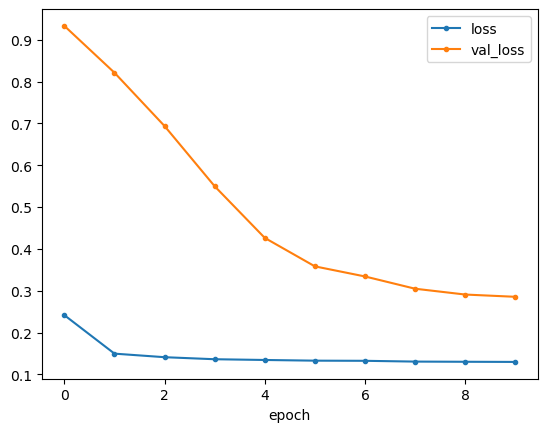

In [22]:
plot_history(history, ['loss', 'val_loss'])

## Computing Threshold Value
The network predicts 4 output channels:
1. The denoised input.
2. The foreground likelihoods.
3. The background likelihoods.
4. The border likelihoods.

We will threshold the foreground prediction image to obtain object segmentations. The optimal threshold is determined on the validation data. Additionally we can optimize the threshold for a given measure. In this case we choose the Average Precision (AP) measure.

In [35]:
threshold, val_score = model.optimize_thresholds(val_images.astype(np.float32), val_masks, measure=measure_precision(), axes='YX')

print("The higest score of {} is achieved with threshold = {}.".format(np.round(val_score, 3), threshold))

Computing best threshold: 


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [36]:
threshold, val_score = model.optimize_thresholds(val_images.astype(np.float32), val_masks, measure=measure_precision(), axes='YX')

print("The higest score of {} is achieved with threshold = {}.".format(np.round(val_score, 3), threshold))

Exception ignored in: <function tqdm.__del__ at 0x7fdded743550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/usr/local/lib/python3.8/dist-packages/tqdm/notebook.py", line 287, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


Computing best threshold: 


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

## Test Data
Finally we load the test data and run the prediction.

In [32]:
test_data =  np.load('data/Mouse_{}/test/test_data.npz'.format(noise_level), allow_pickle=True)
test_images = test_data['X_test']
test_masks = test_data['Y_test']

In [33]:
predicted_denoised, predicted_images, precision_result, _ = model.predict_denoised_label_masks(test_images,
                                                                                               test_masks,
                                                                                               axes='YX',
                                                                                               threshold=threshold,
                                                                                               measure=measure_precision())
print("Average precision over all test images with threshold = {} is {}.".format(threshold, np.round(precision_result, 3)))

Exception ignored in: <function tqdm.__del__ at 0x7fdded743550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/usr/local/lib/python3.8/dist-packages/tqdm/notebook.py", line 287, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x7fdded743550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/usr/local/lib/python3.8/dist-packages/tqdm/notebook.py", line 287, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


NameError: name 'threshold' is not defined

### Visualize the results

NameError: name 'predicted_images' is not defined

<Figure size 640x480 with 0 Axes>

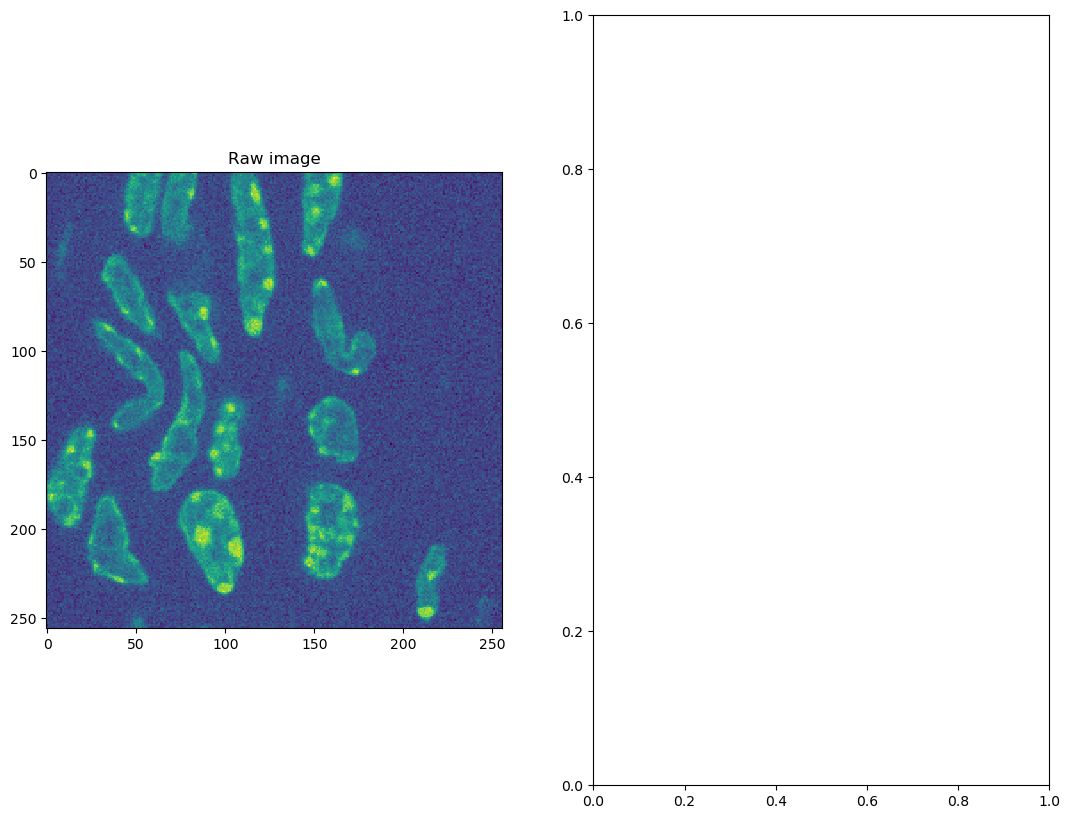

In [37]:
sl = 0
fig = plt.figure()
plt.figure(figsize=(20,10))
plt.subplot(1, 3, 1)
plt.imshow(test_images[sl])
plt.title("Raw image")

plt.subplot(1, 3, 2)
plt.imshow(predicted_images[sl])
plt.title("Predicted segmentation")

plt.subplot(1, 3, 3)
plt.imshow(test_masks[sl])
plt.title("Ground truth segmentation")

plt.show()

In [ ]:
print("Number of annotated images used for training:", number_of_annotated_training_images)
print("Noise level:", noise_level)
print("Considered alpha:", conf.denoiseg_alpha)

### Expected results for this dataset

<b>AP scores for Mouse n0 dataset</b>

||5 imgs|10 imgs|19 imgs|38 imgs|76 imgs|
|--- |--- |--- |--- |--- |--- |
|Alpha 0.5|0.414±0.034|0.432±0.021|0.516±0.005|0.523±0.011|0.544±0.006|
|Alpha 0.3|0.433±0.021|0.453±0.022|0.507±0.009|0.513±0.017|0.552±0.008|
|Alpha 0.7|0.437±0.021|0.403±0.018|0.506±0.013|0.539±0.004|0.540±0.011|
|Alpha best|0.462±0.019|0.484±0.020|0.539±0.003|0.546±0.004|0.571±0.003|

<b>AP scores for Mouse n10 dataset</b>

||5 imgs|10 imgs|19 imgs|38 imgs|76 imgs|
|--- |--- |--- |--- |--- |--- |
|Alpha 0.5|0.449±0.025|0.491±0.025|0.515±0.007|0.534±0.010|0.559±0.009|
|Alpha 0.3|0.458±0.021|0.462±0.025|0.502±0.009|0.513±0.009|0.561±0.009|
|Alpha 0.7|0.423±0.014|0.439±0.027|0.529±0.006|0.544±0.007|0.569±0.008|
|Alpha best|0.497±0.021|0.502±0.023|0.558±0.002|0.558±0.006|0.586±0.006|

<b>AP scores for Mouse n20 dataset</b>

||5 imgs|10 imgs|19 imgs|38 imgs|76 imgs|
|--- |--- |--- |--- |--- |--- |
|Alpha 0.5|0.489±0.023|0.495±0.023|0.541±0.011|0.553±0.011|0.560±0.006|
|Alpha 0.3|0.477±0.022|0.465±0.031|0.523±0.006|0.529±0.010|0.545±0.005|
|Alpha 0.7|0.449±0.008|0.481±0.022|0.533±0.011|0.560±0.007|0.581±0.004|
|Alpha best|0.538±0.011|0.524±0.020|0.562±0.004|0.571±0.004|0.591±0.006|

### Export your model for Fiji

In [39]:
model.export_TF(name='DenoiSeg - Mouse Nuclei Example', 
                description='This is the 2D DenoiSeg example trained on Mouse Nuclei data in python.', 
                authors=["Tim-Oliver Buchholz", "Mangal Prakash", "Alexander Krull", "Florian Jug"],
                test_img=X_val[0,...,0], axes='YX',
                patch_shape=(128, 128))



TypeError: export_TF() missing 1 required positional argument: 'test_img'